# Differential reddening correction of Terzan 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

## The reddenened CMD
We read the data and select only the ones that don't present saturated values. 

In [2]:
df = pd.read_fwf('Ter5xymag.txt', delimiter='')

Flag the values with errors (like mag 99.999, saturated).

In [3]:
# add new column of ones as flag
flag = np.ones(len(df))
df['flag'] = flag

# change flag to 0 if F606W or F814W is saturated
df.loc[(df['F606W'] > 99) | (df['F814W'] > 99), 'flag'] = 0

data = df[df['flag' ]== 1.0]
print(data)


             X        Y    F606W    F814W  flag
0      2630.52  3907.54  27.2402  22.3182   1.0
1      2652.88  3909.42  26.8100  23.6855   1.0
2      2600.77  3916.65  21.4564  18.1027   1.0
3      2983.68  3918.88  26.0843  23.2045   1.0
4      3014.33  3924.09  20.9049  17.8498   1.0
...        ...      ...      ...      ...   ...
34699  7056.14  8983.33  26.6100  23.3153   1.0
34700  7594.54  8986.10  26.0955  23.1290   1.0
34701  7293.35  8987.60  26.8573  23.8102   1.0
34702  7519.02  8992.00  25.9251  22.6812   1.0
34703  7623.03  8993.07  26.0689  23.2574   1.0

[34704 rows x 5 columns]


In [4]:
# Terzan 5
data['Color'] = data['F606W'] - data['F814W']
data['Magnitude'] = data['F814W']

Plot the CMD affected by reddening. 

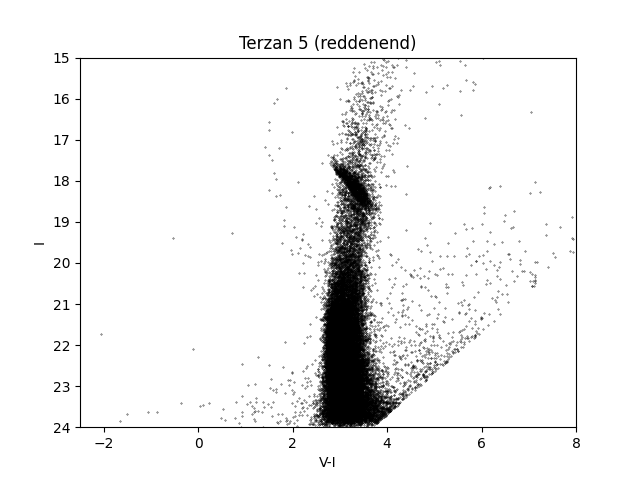

In [5]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'V-I')
plt.ylabel(r'I')
plt.title('Terzan 5 (reddenend)')
plt.show()

## Differential reddening correction
Here we use the procedure and the values described in [Massari et. al 2012](https://iopscience.iop.org/article/10.1088/2041-8205/755/2/L32/pdf). 
We know that $R_I = A_I/E(B-V)$ and $R_V = A_V/E(B-V)$

The slope of the reddening vector is given by 
$$
\text{Slope} = \frac{R_I}{R_V-R_I}
$$

The slope indicates the direction and magnitude of the shift in the CMD due to the reddening. 

In [6]:
R_V = 2.83          # R_F606W
R_I = 1.82          # R_F814W

# plot the reddening vector
slope = (R_I)/(R_V-R_I)
E_BV = 0.2
delta_VI = (R_V-R_I)*E_BV
delta_I = R_I*E_BV

color_0 = 4
mag_0 = 20

color_1 = color_0 + delta_VI    
mag_1 = mag_0 + delta_I

### Reddening vector

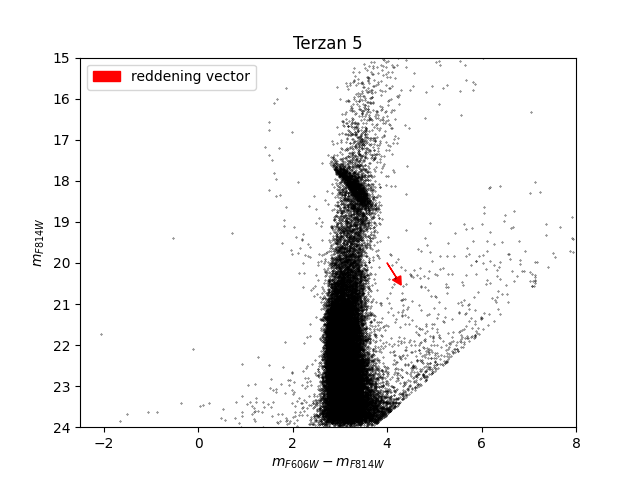

In [7]:
# plot reddening vector as an arrow
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.arrow(color_0, mag_0, color_1-color_0, mag_1-mag_0, head_width=0.2, head_length=0.2, fc='red', ec='red', label='reddening vector')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('Terzan 5')
plt.show()

To correct for differential reddening we first divide the field of view in sectors.

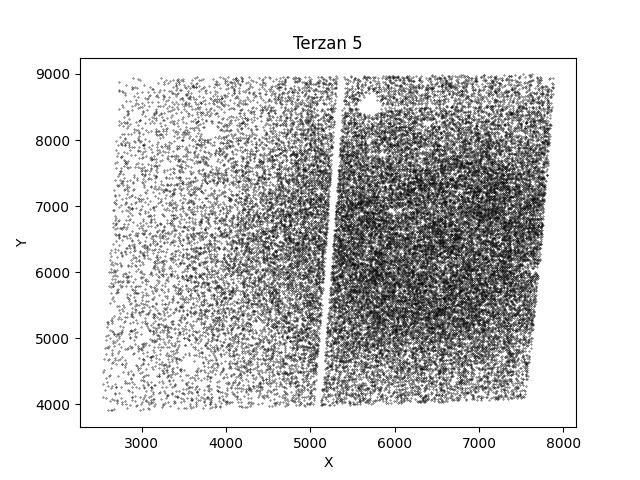

In [8]:
plt.figure()
plt.plot(data['X'], data['Y'], 'o', markersize=0.3, color='black')
plt.xlabel('X')
plt.ylabel('Y') 
plt.title('Terzan 5')   
plt.show()

In [9]:
n_sectors_x = 30  # Number of sectors along x
n_sectors_y = 30  # Number of sectors along y
x_bins = np.linspace(data['X'].min(), data['X'].max(), n_sectors_x+1)
y_bins = np.linspace(data['Y'].min(), data['Y'].max(), n_sectors_y+1)

# assign a sector to each data point
data['Sector'] = -1
sector_colors = []

for i in range(n_sectors_x):
    for j in range(n_sectors_y):
        sector_index = i * n_sectors_y + j
        sector_colors.append(sector_index)
        sector_data = (data['X'] >= x_bins[i]) & (data['X'] < x_bins[i+1]) & \
                      (data['Y'] >= y_bins[j]) & (data['Y'] < y_bins[j+1])
        data.loc[sector_data, 'Sector'] = sector_index


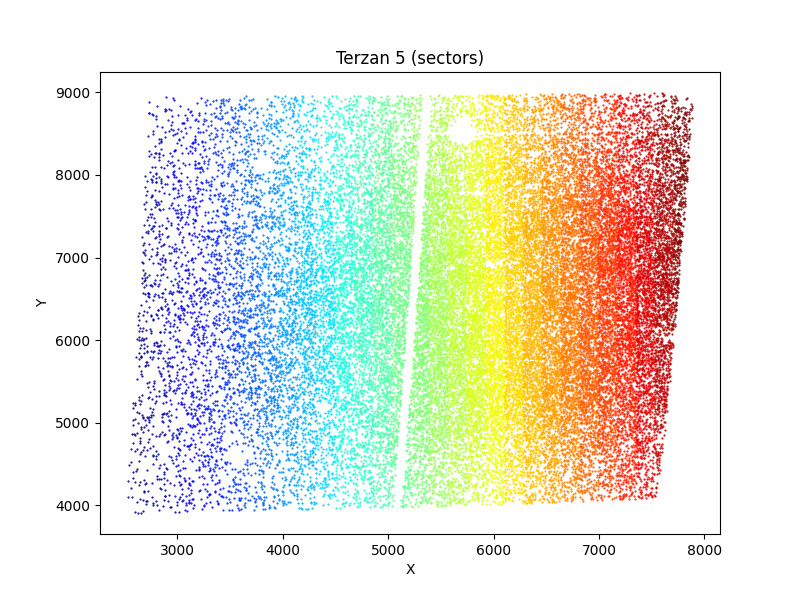

In [10]:
# plot the sensor sectors with different colors
plt.figure(figsize=(8, 6))
colors = plt.cm.jet(np.linspace(0, 1, n_sectors_x * n_sectors_y))

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['X'], sector_data['Y'], color=colors[sector_index], s=0.3, label=f'Sector {sector_index}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Terzan 5 (sectors)')
plt.show()

Now that the sensor is divided in sector we plot the CMD for each sector (in the same plot, the color of the CMD is the same as the sector in the sensor). The black dashed lines indicates approximately the position of the red clump. 

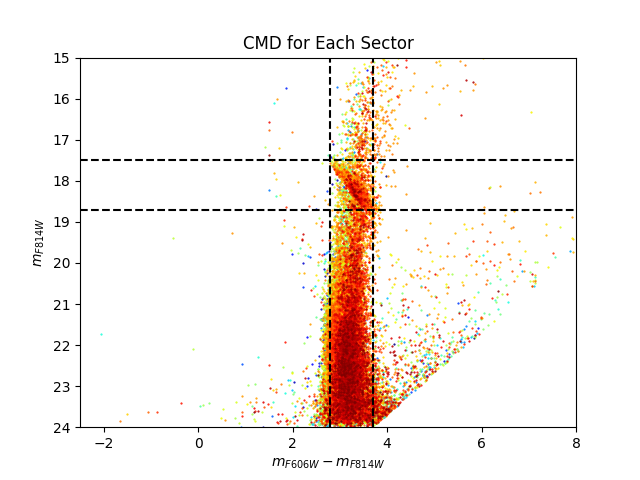

In [11]:
# plot the CMD for all sectors on the same figure
plt.figure()

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'], sector_data['F814W'], color=colors[sector_index], s=0.3)

# red clump region
plt.axvline(x=2.8, color='black', linestyle='--')
plt.axvline(x=3.7, color='black', linestyle='--')
plt.axhline(y=18.7, color='black', linestyle='--')
plt.axhline(y=17.5, color='black', linestyle='--')

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('CMD for Each Sector')
plt.show()

Now for each sector we select the red clump stars and compute the mean point. 

In [12]:
# Select Red Clump (RC) stars
rc_data = data[(data['F606W'] - data['F814W'] >= 2.8) & (data['F606W'] - data['F814W'] <= 3.7) &
               (data['F814W'] >= 17.5) & (data['F814W'] <= 18.7)]

# Calculate the mean point of RC stars for each sector
mean_points = []
color_excesses = []
mag_excesses = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_rc_data = rc_data[rc_data['Sector'] == sector_index]
    if not sector_rc_data.empty:
        mean_color = (sector_rc_data['F606W'] - sector_rc_data['F814W']).mean()
        mean_mag = sector_rc_data['F814W'].mean()
        mean_points.append((mean_color, mean_mag))
    else:
        mean_points.append((np.nan, np.nan))


We look for the sector with the lower standard deviation and we take it as a reference sector (the position of the mean point is the best approximation of all the points). 

In [13]:
# compute the sector with the lowest standard deviation
stds = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_rc_data = rc_data[rc_data['Sector'] == sector_index]
    if not sector_rc_data.empty:
        std = (sector_rc_data['F606W']-sector_rc_data['F814W']).std()
        stds.append(std)
    else:
        stds.append(np.nan)

min_std_sector = np.nanargmin(stds)
print(f'Sector with the lowest standard deviation: {min_std_sector}')

Sector with the lowest standard deviation: 437


Now we compute, for each sector, the difference between the mean point and the mean point of the reference sector. This difference represent the color excess and the magnitude excess. 

Once we have done that we can plot the corrected CMD simply subtracting the color excess and the mag excess from the color index and the magnitude, respectively.

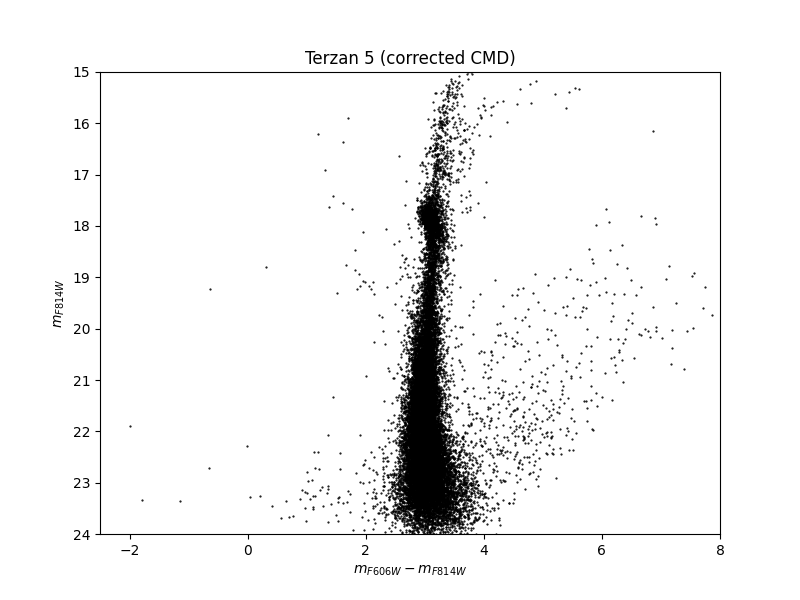

In [16]:
# compute for each sector the difference between the mean point and the minimum standard deviation sector
for sector_index in range(n_sectors_x * n_sectors_y):
    color_excess = mean_points[sector_index][0] - mean_points[min_std_sector][0]
    mag_excess = mean_points[sector_index][1] - mean_points[min_std_sector][1]
    color_excesses.append(color_excess)
    mag_excesses.append(mag_excess)

# plot the CMD for all sectors on the same figure
plt.figure(figsize=(8, 6))

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color='black', s=0.3)
    
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Terzan 5 (corrected CMD)')
plt.show()


To see the difference between the corrected CMD and the original one we can plot them in the same figure. The black CMD is the original one, the colored one is the corrected.  

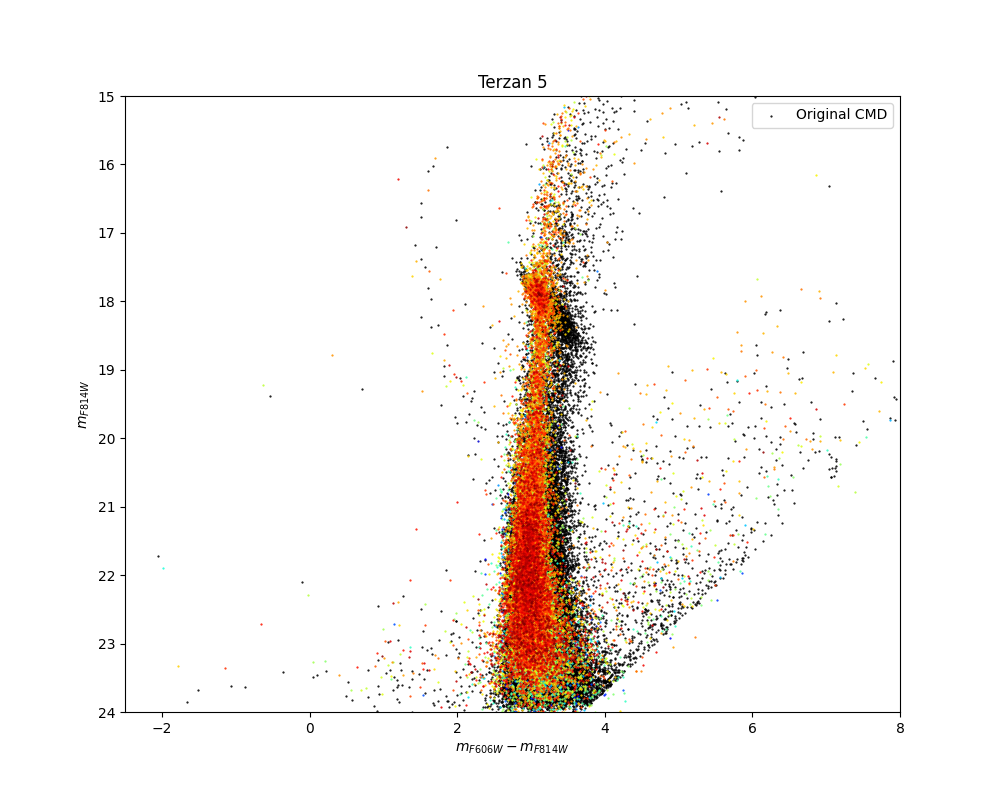

In [15]:
# compare the corrected CMD with the one affected by differential reddening on the same plot
plt.figure(figsize=(10, 8))

plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3, label='Original CMD')

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color=colors[sector_index], s=0.3)

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend()
plt.title('Terzan 5')
plt.show()

